In [1]:
# import data manipulation and visualisation libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# import nltk libraries for text mining
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [2]:
# import cleaned and labelled Osha accident cases dataset
df_osha = pd.read_csv('osha_fatal_clean_cause_labelled.csv')

In [3]:
# drop the unused columns
df_osha = df_osha.drop(["Unnamed: 0"], axis = 1)

In [4]:
# inspect the dataset
df_osha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6568 entries, 0 to 6567
Data columns (total 6 columns):
incident_ID                    6568 non-null int64
title                          6568 non-null object
description                    6568 non-null object
cause                          6568 non-null object
title_description              6568 non-null object
title_description_processed    6568 non-null object
dtypes: int64(1), object(5)
memory usage: 308.0+ KB


In [5]:
# build a stopword dictionary with verb and noun that are not related to activity conducted during accident
verb_stopwords = set(['killing', 'lying', 'causing'])
noun_stopwords = set(['hospital', 'ambulance', 'treatment', 'amputation', 'explosion', 'boom', 'accident', \
                      'laborer', 'employee', 'coworker', 'crew', 'carpenter', 'painter', 'employer', 'operator', \
                      'firm', 'company', 'facility'])

In [6]:
# define a function for text mining with the following steps:
# 1. tokenize the string for each row
# 2. convert each of the token to lower case
# 3. remove verb stopwords
# 4. remove noun stopwords
# 5. pos-tag each of the token
# 6. return the pos-tagged tokens
def pre_process(text):
    tokens = nltk.word_tokenize(text)
    tokens_lower = [ word.lower() for word in tokens ]
    tokens_nostop_verb = [word for word in tokens_lower if word not in verb_stopwords]
    tokens_nostop_noun = [word for word in tokens_nostop_verb if word not in noun_stopwords]
    tokens_pos = pos_tag(tokens_nostop_noun)  
    return(tokens_pos)

In [7]:
# apply the "pre_process" function on each row of "decription" column of labelled Osha accident cases dataset
df_osha['description_processed'] = df_osha['description'].apply(pre_process)

In [8]:
# define the grammar to capture activity conducted during the accident happened
grammar = r'''
ACT: {<VBG><RB|IN|DT>+<JJ.>?<N.*>+}
'''
chunker = nltk.RegexpParser(grammar)

In [9]:
# Loop through each row of 'description_processed' column and capture the trms with predefined grammar structure
empty_list = []
for text in df_osha['description_processed']:
    tree = chunker.parse(text)
    for subtree in tree.subtrees():
        if subtree.label() == 'ACT':
            subtree = str(subtree.flatten())
            tree = nltk.Tree.fromstring(subtree, read_leaf=lambda x: x.split("/")[0])   
            empty_list.append(tree.leaves())

In [10]:
# Join each item in the activity list to be a activity string
activity_list = []
for item in empty_list:
    activity_list.append(" ".join(item))

In [11]:
# store the activity extracted in a dataframe
df_activity = pd.DataFrame(data=activity_list)
df_activity = df_activity.rename(columns={0: "activity"})

In [12]:
# calculate the number of top 30  activity that cause accidents
df_activity['activity'].value_counts().head(20)

standing in front                 21
standing on top                   20
wearing a harness                 20
working on the roof               18
wearing a seat belt               17
standing on the ground            16
using a forklift                  15
operating a forklift              14
operating the controls            12
wearing a safety harness          11
working on top                    11
operating the forklift            10
delivering a load                 10
working alone at the time          9
striking the in the head           9
operating a john                   9
wearing a seatbelt                 9
clearing a jam                     8
working from a ladder              8
working at a construction site     8
Name: activity, dtype: int64

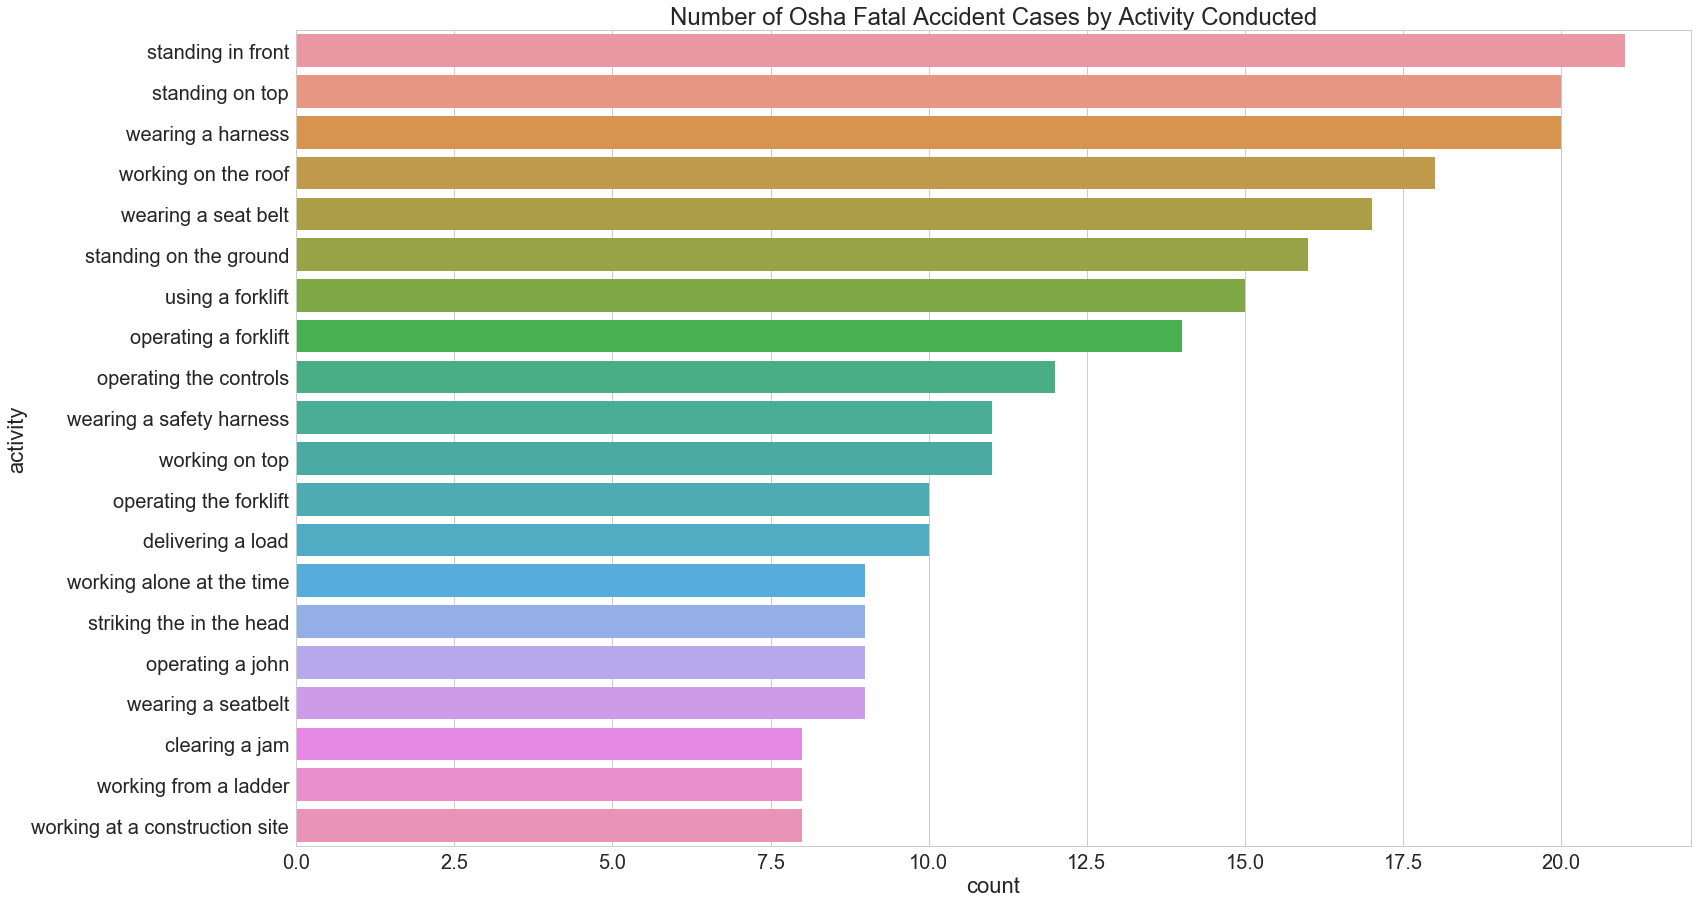

In [13]:
# plot the barchart of the top 20 number of activity that cause accidents
plt.figure(figsize=(25,15))
sns.set(style="whitegrid", font_scale=2)
ax = sns.countplot(y="activity", data=df_activity, order=df_activity['activity'].value_counts().head(20).index)
ax.set_title('Number of Osha Fatal Accident Cases by Activity Conducted')
plt.show()

## Further Analysis

In [14]:
# Concatenate all the activity into one huge text file
activity_text = ""
for activity in df_activity['activity']:
    activity_text += " " + activity

In [15]:
# tokenize the text file, remove the English stopwords and punctiation
mystopwords = stopwords.words("English")
words = nltk.word_tokenize(activity_text)
words_nop = [word for word in words if word not in string.punctuation]
words_nostop = [word for word in words_nop if word not in mystopwords]

In [16]:
# pos-tag each of the word in the activity word list
words_tag = nltk.pos_tag(words_nostop)

In [17]:
# create a new word list from the original word list with only noun
word_tag_noun = []
for word, tag in words_tag:
    if tag.startswith('NN'):
        word_tag_noun.append(word)

In [18]:
# create a new word list from the original word list with only verb
word_tag_verb = []
for word, tag in words_tag:
    if tag.startswith('VB'):
        word_tag_verb.append(word)

In [19]:
# store the activity words extracted in a dataframe
df_activity_word = pd.DataFrame(data=words_nostop)
df_activity_word = df_activity_word.rename(columns={0: "word"})

In [20]:
# calculate the top 20 number of activity word
df_activity_word['word'].value_counts().head(20)

working       1050
using          485
operating      419
standing       285
wearing        150
truck          136
removing       130
holding        126
driving        116
machine        106
moving          92
installing      87
forklift        85
walking         85
cleaning        83
ladder          81
top             80
roof            79
line            77
ground          75
Name: word, dtype: int64

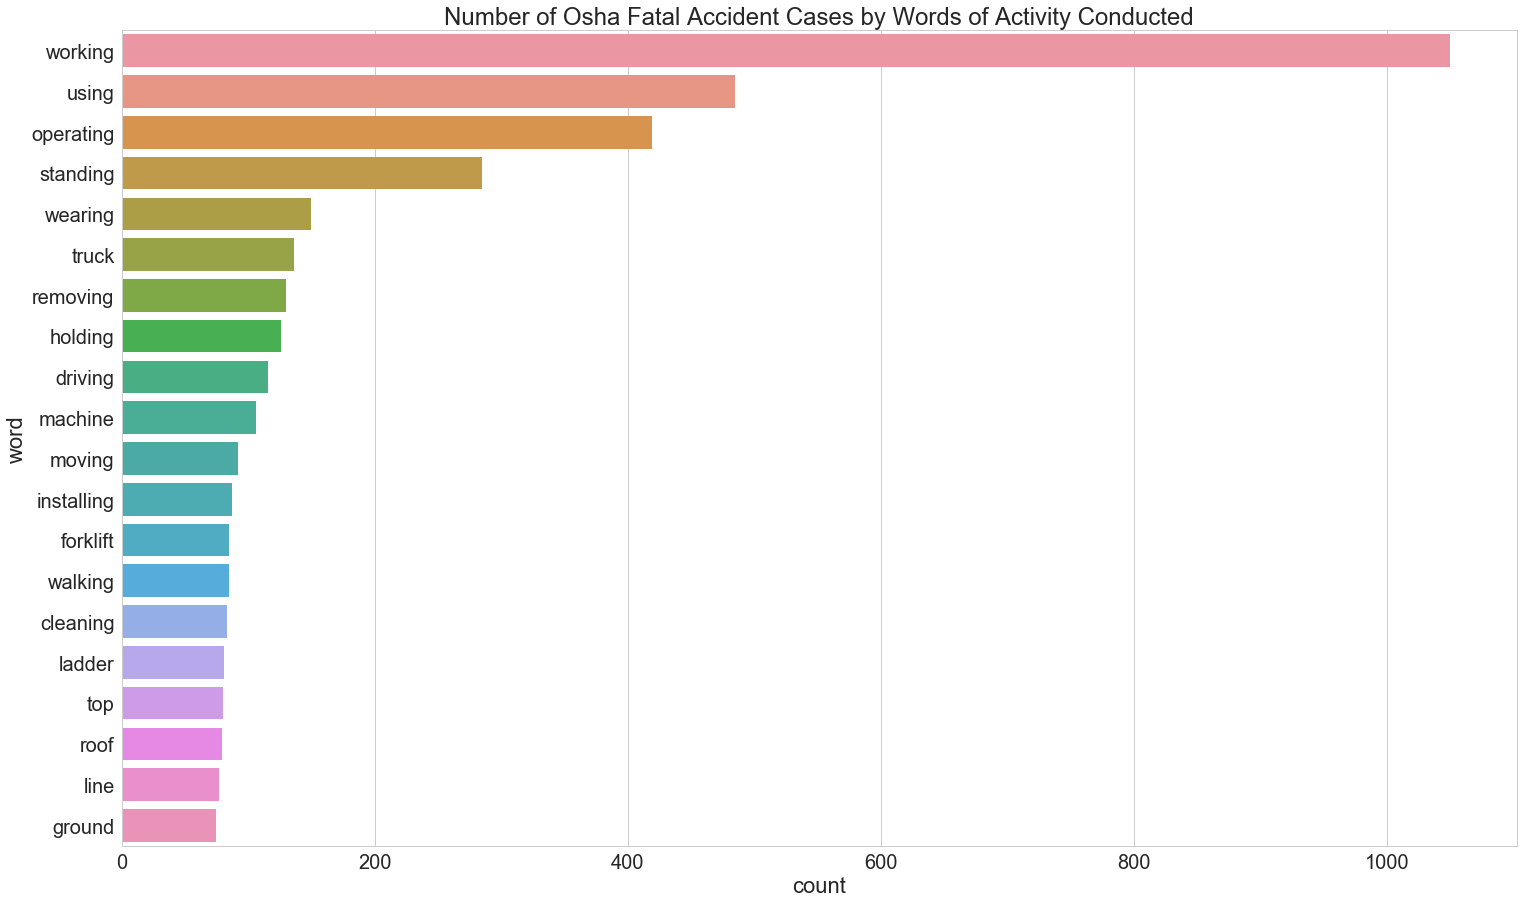

In [21]:
# plot the top 20 number of activity word
plt.figure(figsize=(25,15))
sns.set(style="whitegrid", font_scale=2)
ax = sns.countplot(y="word", data=df_activity_word, order=df_activity_word['word'].value_counts().head(20).index)
ax.set_title('Number of Osha Fatal Accident Cases by Words of Activity Conducted')
plt.show()

In [22]:
# store the activity noun extracted in a dataframe
df_activity_noun = pd.DataFrame(data=word_tag_noun)
df_activity_noun = df_activity_noun.rename(columns={0: "noun"})

In [23]:
# calculate the top 20 number of activity noun
df_activity_noun['noun'].value_counts().head(20)

truck           136
machine         106
line             77
ground           75
area             70
forklift         69
crane            65
tank             61
load             58
construction     53
floor            53
air              51
tractor          50
platform         49
water            49
site             47
work             47
system           43
bucket           42
roof             42
Name: noun, dtype: int64

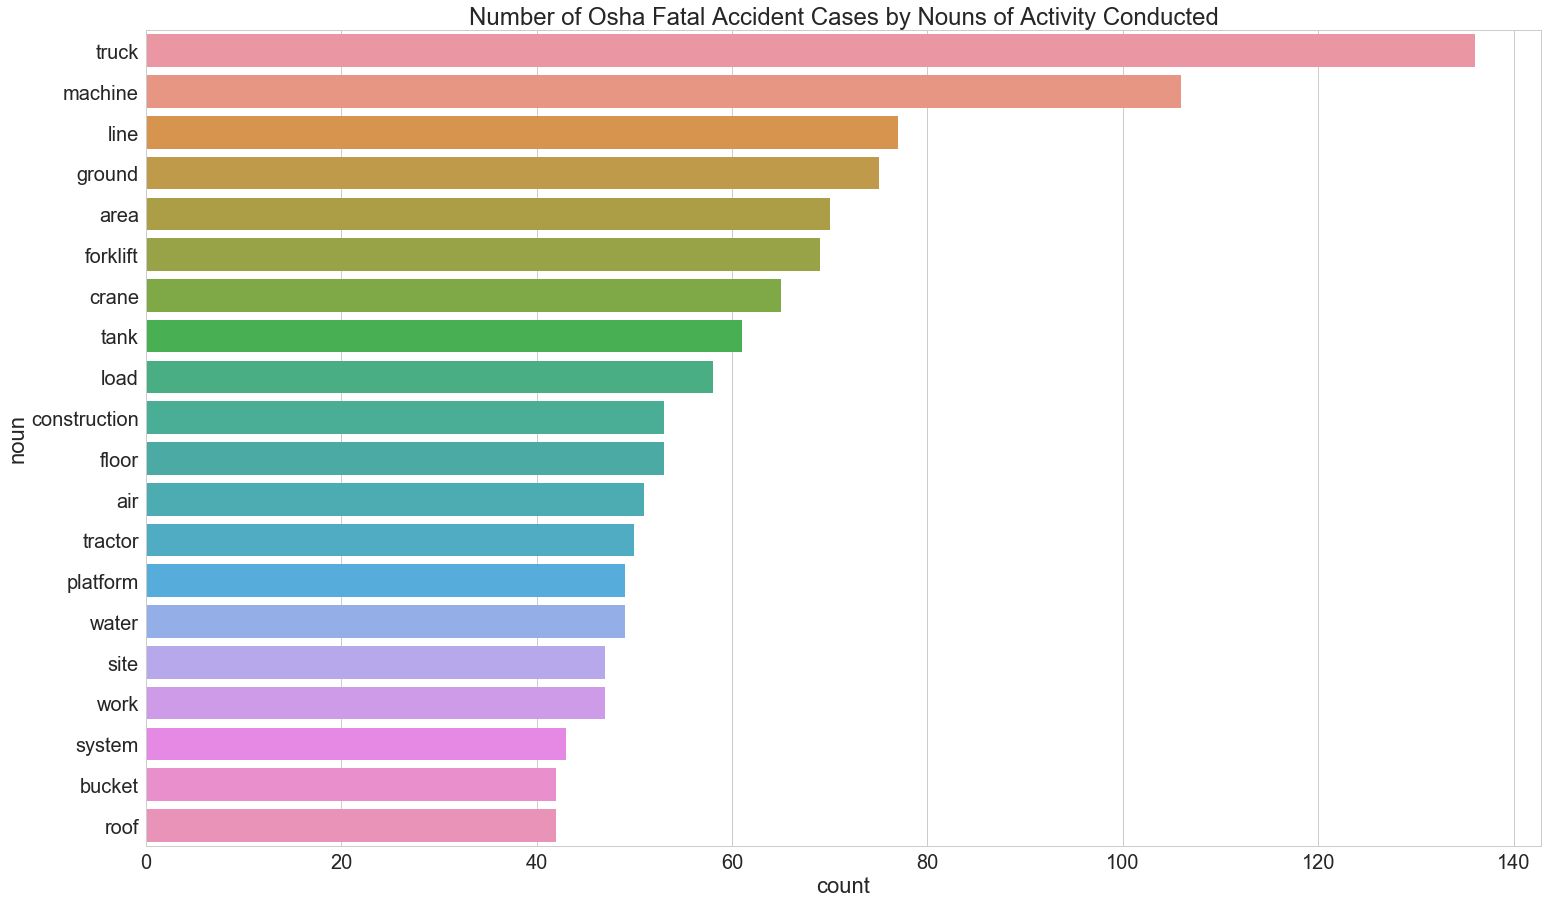

In [24]:
# plot the top 20 number of activity noun
plt.figure(figsize=(25,15))
sns.set(style="whitegrid", font_scale=2)
ax = sns.countplot(y="noun", data=df_activity_noun, order=df_activity_noun['noun'].value_counts().head(20).index)
ax.set_title('Number of Osha Fatal Accident Cases by Nouns of Activity Conducted')
plt.show()

In [25]:
# store the activity verbs extracted in a dataframe
df_activity_verb = pd.DataFrame(data=word_tag_verb)
df_activity_verb = df_activity_verb.rename(columns={0: "verb"})

In [26]:
# calculate the top 20 number of activity verb
df_activity_verb['verb'].value_counts().head(20)

working       1038
using          485
operating      385
standing       276
wearing        147
removing       127
holding        126
driving        109
moving          92
installing      84
walking         83
cleaning        69
pulling         67
sitting         62
cutting         57
performing      52
repairing       48
striking        48
riding          47
running         47
Name: verb, dtype: int64

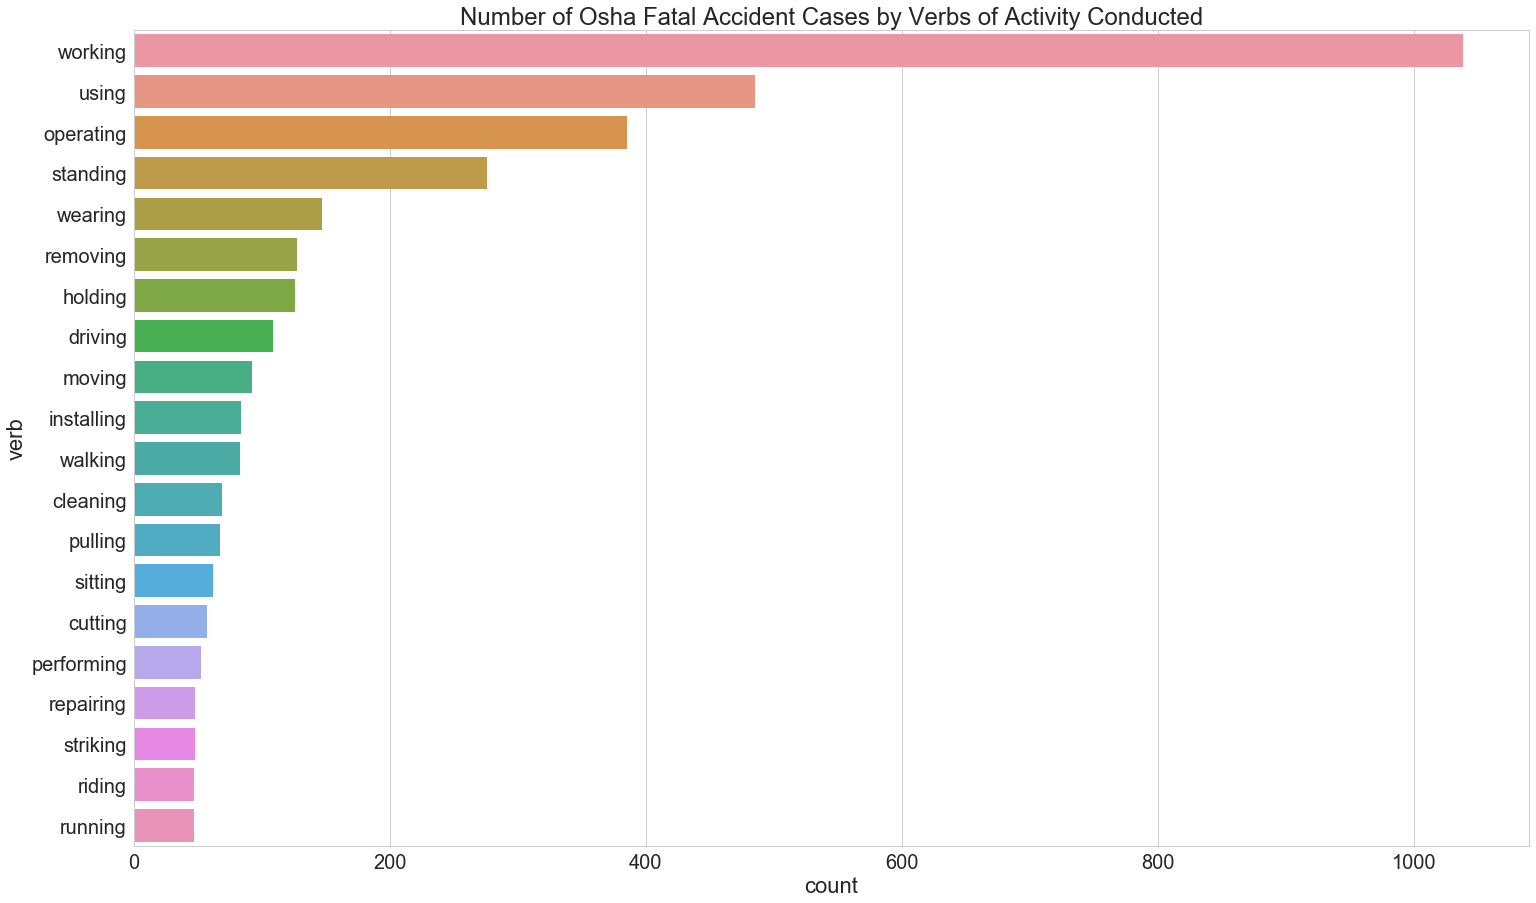

In [27]:
# plot the top 20 number of activity verb
plt.figure(figsize=(25,15))
sns.set(style="whitegrid", font_scale=2)
ax = sns.countplot(y="verb", data=df_activity_verb, order=df_activity_verb['verb'].value_counts().head(20).index)
ax.set_title('Number of Osha Fatal Accident Cases by Verbs of Activity Conducted')
plt.show()

In [28]:
# join each of the word list into a string
words_nostop_string = ' '.join(word for word in words_nostop)
word_tag_noun_string = ' '.join(word for word in word_tag_noun)
word_tag_verb_string = ' '.join(word for word in word_tag_verb)

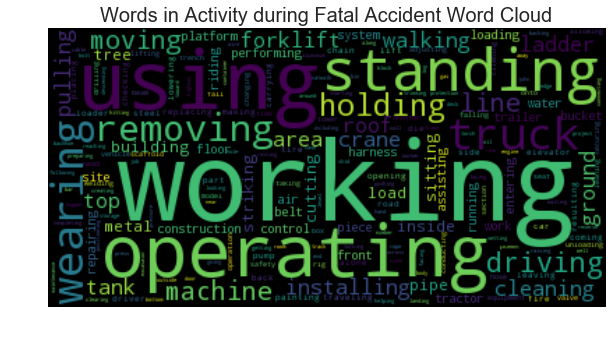

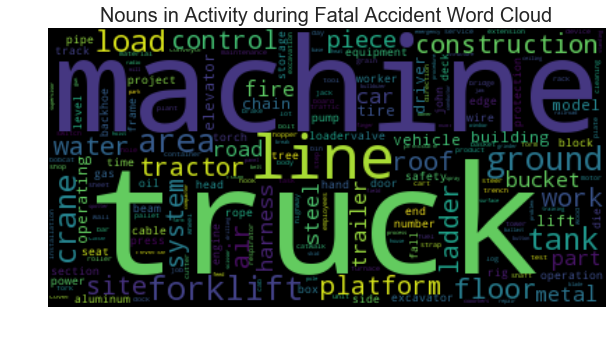

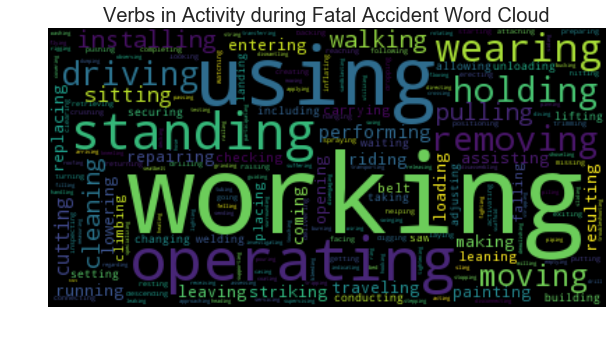

In [29]:
# Generate an all word in activity cloud image
wordcloud = WordCloud(collocations=False).generate(words_nostop_string)
plt.figure(figsize=(10, 8))
plt.title('Words in Activity during Fatal Accident Word Cloud', fontsize = 20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Generate a noun word in activity cloud image
wordcloud = WordCloud(collocations=False).generate(word_tag_noun_string)
plt.figure(figsize=(10, 8))
plt.title('Nouns in Activity during Fatal Accident Word Cloud', fontsize = 20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Generate a verb word in activity cloud image 
wordcloud = WordCloud(collocations=False).generate(word_tag_verb_string)
plt.figure(figsize=(10, 8))
plt.title('Verbs in Activity during Fatal Accident Word Cloud', fontsize = 20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()